# Optional Lab: Linear Regression using Scikit-Learn

There is an open-source, commercially usable machine learning toolkit called [scikit-learn](https://scikit-learn.org/stable/index.html). This toolkit contains implementations of many of the algorithms that you will work with in this course.



## Goals
In this lab you will:
- Utilize  scikit-learn to implement linear regression using Gradient Descent

## Tools
You will utilize functions from scikit-learn as well as matplotlib and NumPy. 

In [2]:
import sys, os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def find_repo_root(marker="README.md"):
    cur = Path.cwd()
    while cur != cur.parent:  # 防止無限迴圈，到達檔案系統根目錄就停
        if (cur / marker).exists():
            return cur
        cur = cur.parent
    return None

def import_data_from_github():
    import urllib.request, shutil
    
    def isRunningInColab() -> bool:
        return "google.colab" in sys.modules

    def isRunningInJupyterLab() -> bool:
        try:
            import jupyterlab
            return True
        except ImportError:
            return False
        
    def detect_env():
        from IPython import get_ipython
        if isRunningInColab():
            return "Colab"
        elif isRunningInJupyterLab():
            return "JupyterLab"
        elif "notebook" in str(type(get_ipython())).lower():
            return "Jupyter Notebook"
        else:
            return "Unknown"
        
    def get_utils_dir(env): 
        if env == "Colab": 
            if "/content" not in sys.path:
                sys.path.insert(0, "/content")
            return "/content/utils"
        else:
            return Path.cwd() / "utils"

    def get_data_dir(env): 
        if env == "Colab": 
            if "/content" not in sys.path:
                sys.path.insert(0, "/content")
            return "/content/data"
        else:
            return Path.cwd() / "data"

    env = detect_env()
    UTILS_DIR = get_utils_dir(env)
    DATA_DIR = get_data_dir(env)
    REPO_DIR = "Machine-Learning-Lab"

    shutil.rmtree(UTILS_DIR, ignore_errors=True)
    os.makedirs(UTILS_DIR, exist_ok=True)

    shutil.rmtree(DATA_DIR, ignore_errors=True)
    os.makedirs(DATA_DIR, exist_ok=True)

    BASE = f"https://raw.githubusercontent.com/mz038197/{REPO_DIR}/main"
    urllib.request.urlretrieve(f"{BASE}/utils/lab_utils_multi.py", f"{UTILS_DIR}/lab_utils_multi.py")
    urllib.request.urlretrieve(f"{BASE}/utils/lab_utils_common.py", f"{UTILS_DIR}/lab_utils_common.py")
    urllib.request.urlretrieve(f"{BASE}/utils/deeplearning.mplstyle", f"{UTILS_DIR}/deeplearning.mplstyle")
    urllib.request.urlretrieve(f"{BASE}/data/houses.txt", f"{DATA_DIR}/houses.txt")

repo_root = find_repo_root()

if repo_root is None:
    import_data_from_github()
    repo_root = Path.cwd()
    
os.chdir(repo_root)
print(f"✅ 切換工作目錄至 {Path.cwd()}")
sys.path.append(str(repo_root)) if str(repo_root) not in sys.path else None
print(f"✅ 加入到系統路徑")

from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from utils.lab_utils_multi import  load_house_data
from utils.lab_utils_common import dlc
np.set_printoptions(precision=2) 
plt.style.use('utils/deeplearning.mplstyle')

print("✅ 匯入模組及設定繪圖樣式")

✅ 切換工作目錄至 d:\Work\Python\Machine-Learning-Lab
✅ 加入到系統路徑
✅ 匯入模組及設定繪圖樣式


# Gradient Descent
Scikit-learn has a gradient descent regression model [sklearn.linear_model.SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#examples-using-sklearn-linear-model-sgdregressor).  Like your previous implementation of gradient descent, this model performs best with normalized inputs. [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) will perform z-score normalization as in a previous lab. Here it is referred to as 'standard score'.

### Load the data set

In [3]:
X_train, y_train = load_house_data()
X_features = ['size(sqft)','bedrooms','floors','age']

### Scale/normalize the training data

In [4]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_train)
print(f"Peak to Peak range by column in Raw        X:{np.ptp(X_train,axis=0)}")   
print(f"Peak to Peak range by column in Normalized X:{np.ptp(X_norm,axis=0)}")

Peak to Peak range by column in Raw        X:[2.406e+03 4.000e+00 1.000e+00 9.500e+01]
Peak to Peak range by column in Normalized X:[5.8452591  6.13529646 2.05626214 3.68533012]


### Create and fit the regression model

In [5]:
sgdr = SGDRegressor(max_iter=1000)
sgdr.fit(X_norm, y_train)
print(sgdr)
print(f"number of iterations completed: {sgdr.n_iter_}, number of weight updates: {sgdr.t_}")

SGDRegressor()
number of iterations completed: 125, number of weight updates: 12376.0


### View parameters
Note, the parameters are associated with the *normalized* input data. The fit parameters are very close to those found in the previous lab with this data.

In [6]:
b_norm = sgdr.intercept_
w_norm = sgdr.coef_
print(f"model parameters:                   w: {w_norm}, b:{b_norm}")
print( "model parameters from previous lab: w: [110.56 -21.27 -32.71 -37.97], b: 363.16")

model parameters:                   w: [110.14925466 -21.05719931 -32.46361853 -38.05227021], b:[363.17724363]
model parameters from previous lab: w: [110.56 -21.27 -32.71 -37.97], b: 363.16


### Make predictions
Predict the targets of the training data. Use both the `predict` routine and compute using $w$ and $b$.

In [7]:
# make a prediction using sgdr.predict()
y_pred_sgd = sgdr.predict(X_norm)
# make a prediction using w,b. 
y_pred = np.dot(X_norm, w_norm) + b_norm  
print(f"prediction using np.dot() and sgdr.predict match: {(y_pred == y_pred_sgd).all()}")

print(f"Prediction on training set:\n{y_pred[:4]}" )
print(f"Target values \n{y_train[:4]}")

prediction using np.dot() and sgdr.predict match: True
Prediction on training set:
[295.18873477 485.93889217 389.62720606 492.10243829]
Target values 
[300.  509.8 394.  540. ]


### Plot Results
Let's plot the predictions versus the target values.

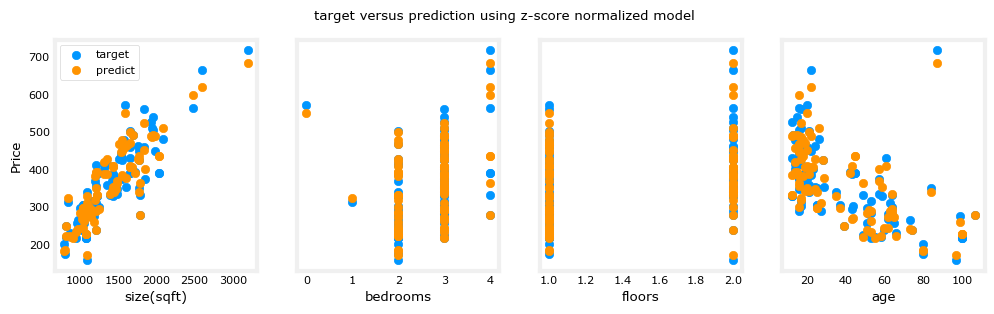

In [8]:
# plot predictions and targets vs original features    
fig,ax=plt.subplots(1,4,figsize=(12,3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train[:,i],y_pred,color=dlc["dlorange"], label = 'predict')
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()

## Congratulations!
In this lab you:
- utilized an open-source machine learning toolkit, scikit-learn
- implemented linear regression using gradient descent and feature normalization from that toolkit